In [1]:
import numpy
import scipy
import numpy as np 
import time 
import math
import matplotlib.pyplot as plt
import cupy as cp
from math import sqrt

In [2]:
'Spline Implementation for 1D in CPU with Numpy'

def cubic_interp1d(x0, x, y):
    """
    Interpolate a 1-D function using cubic splines.
      x0 : a float or an 1d-array
      x : (N,) array_like
          A 1-D array of real/complex values.
      y : (N,) array_like
          A 1-D array of real values. The length of y along the
          interpolation axis must be equal to the length of x.

    Implement a trick to generate at first step the cholesky matrice L of
    the tridiagonal matrice A (thus L is a bidiagonal matrice that
    can be solved in two distinct loops).

    additional ref: www.math.uh.edu/~jingqiu/math4364/spline.pdf 
    """
    x = np.asfarray(x)
    y = np.asfarray(y)
    
    # check if sorted
    if np.any(np.diff(x) < 0):
        indexes = np.argsort(x)
        x = x[indexes]
        y = y[indexes]

    size = len(x)

    xdiff = np.diff(x)
    ydiff = np.diff(y)

    # allocate buffer matrices
    Li = np.empty(size)
    Li_1 = np.empty(size-1)
    z = np.empty(size)

    # fill diagonals Li and Li-1 and solve [L][y] = [B]
    Li[0] = sqrt(2*xdiff[0])
   
    Li_1[0] = 0.0
    B0 = 0.0 # natural boundary
    z[0] = B0 / Li[0]

    for i in range(1, size-1, 1):
        Li_1[i] = xdiff[i-1] / Li[i-1]
        Li[i] = sqrt(2*(xdiff[i-1]+xdiff[i]) - Li_1[i-1] * Li_1[i-1])
        Bi = 6*(ydiff[i]/xdiff[i] - ydiff[i-1]/xdiff[i-1])
        z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    i = size - 1
    Li_1[i-1] = xdiff[-1] / Li[i-1]
    Li[i] = sqrt(2*xdiff[-1] - Li_1[i-1] * Li_1[i-1])
    Bi = 0.0 # natural boundary
    z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    # solve [L.T][x] = [y]
    i = size-1
    z[i] = z[i] / Li[i]
    for i in range(size-2, -1, -1):
        z[i] = (z[i] - Li_1[i-1]*z[i+1])/Li[i]

    # find index
    index = np.searchsorted(x,x0)
    
    np.clip(index, 1, size-1, index)

    xi1, xi0 = x[index], x[index-1]
    yi1, yi0 = y[index], y[index-1]
    zi1, zi0 = z[index], z[index-1]
    hi1 = xi1 - xi0

    # calculate cubic
    f0 = zi0/(6*hi1)*(xi1-x0)**3 + \
         zi1/(6*hi1)*(x0-xi0)**3 + \
         (yi1/hi1 - zi1*hi1/6)*(x0-xi0) + \
         (yi0/hi1 - zi0*hi1/6)*(xi1-x0)
    
    return f0



In [3]:
'Spline Implementation for 1D in GPU with CuPy'

def cubic_interp1d_gpu(x0, x, y):
    """
    Interpolate a 1-D function using cubic splines.
      x0 : a float or an 1d-array
      x : (N,) array_like
          A 1-D array of real/complex values.
      y : (N,) array_like
          A 1-D array of real values. The length of y along the
          interpolation axis must be equal to the length of x.

    Implement a trick to generate at first step the cholesky matrice L of
    the tridiagonal matrice A (thus L is a bidiagonal matrice that
    can be solved in two distinct loops).

    additional ref: www.math.uh.edu/~jingqiu/math4364/spline.pdf 
    """

    x = cp.array(x, dtype='float')
    y = cp.array(y, dtype='float')
    

    # check if sorted
    if cp.any(cp.diff(x) < 0):
        indexes = cp.argsort(x)
        x = x[indexes]
        y = y[indexes]

    size = len(x)

    xdiff = cp.diff(x)
    ydiff = cp.diff(y)

    # allocate buffer matrices
    Li = cp.empty(size)
    Li_1 = cp.empty(size-1)
    z = cp.empty(size)

    # fill diagonals Li and Li-1 and solve [L][y] = [B]
    Li[0] = cp.sqrt(2*xdiff[0])
 
    Li_1[0] = 0.0
    B0 = 0.0 # natural boundary
    z[0] = cp.divide(B0,Li[0])

    for i in range(1, size-1, 1):
        Li_1[i] = cp.divide(xdiff[i-1],Li[i-1])
        Li[i] = cp.sqrt(cp.subtract(cp.multiply(2,cp.add(xdiff[i-1],xdiff[i])) ,cp.multiply(Li_1[i-1],Li_1[i-1])))
        Bi = cp.multiply(6,(cp.subtract(cp.divide(ydiff[i],xdiff[i]), cp.divide(ydiff[i-1],xdiff[i-1]))))
        z[i] = cp.divide(cp.subtract(Bi,cp.multiply(Li_1[i-1],z[i-1])),Li[i])

    i = size - 1
    Li_1[i-1] = cp.divide(xdiff[-1],Li[i-1])

    Li[i] = cp.sqrt(cp.subtract(cp.multiply(2,xdiff[-1]), cp.multiply(Li_1[i-1],Li_1[i-1])))
    Bi = 0.0 # natural boundary
    z[i] = cp.divide(cp.subtract(Bi, cp.multiply(Li_1[i-1],z[i-1])),Li[i])

    # solve [L.T][x] = [y]
    i = size-1
    z[i] = cp.divide(z[i] ,Li[i])
    for i in range(size-2, -1, -1):
        z[i] = cp.divide(cp.subtract(z[i],cp.multiply(Li_1[i-1],z[i+1])),Li[i])

    # find index
    
    index = cp.searchsorted(x,x0)
   
    cp.clip(index, 1, size-1, index)

    xi1, xi0 = x[index], x[index-1]
    yi1, yi0 = y[index], y[index-1]
    zi1, zi0 = z[index], z[index-1]
    hi1 = cp.subtract(xi1,xi0)

    f7 =cp.multiply(cp.divide(zi0,cp.multiply(6,hi1)), cp.power(cp.subtract(xi1,x0),3))
    f1 =cp.multiply(cp.divide(zi1,cp.multiply(6,hi1)), cp.power(cp.subtract(x0,xi0),3))
    f2 =cp.multiply(cp.subtract(cp.divide(yi1,hi1),cp.divide(cp.multiply(zi1,hi1),6)),cp.subtract(x0,xi0))
    f3 =cp.multiply(cp.subtract(cp.divide(yi0,hi1),cp.divide(cp.multiply(zi0,hi1),6)),cp.subtract(xi1,x0))
    f4 = cp.add(f7,f1)
    f5 = cp.add(f2,f3)
    f6 = cp.add(f4,f5)
        
    
    return f6



---Time for Spline in GPU 0.007128238677978516 seconds


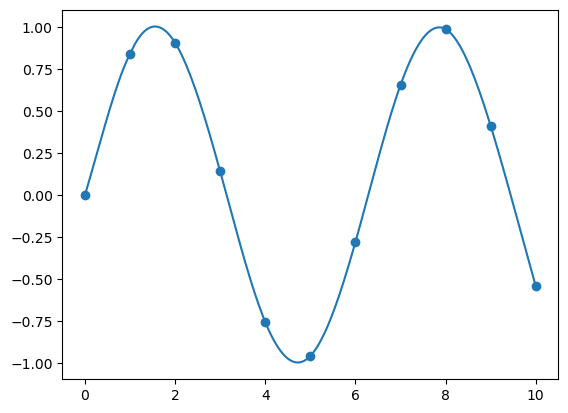

---Time for Spline in CPU 0.0006093978881835938 seconds


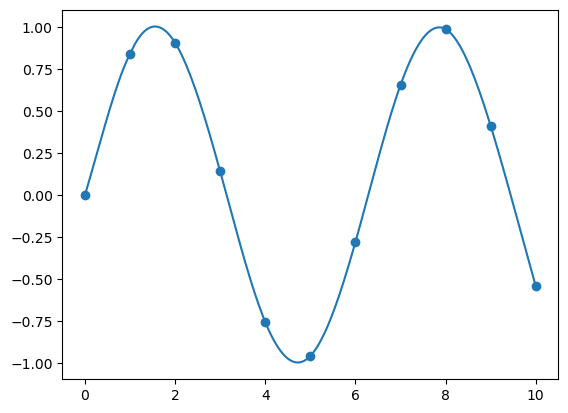

---Time for Spline in GPU with cp.interp 1D 0.0006093978881835938 seconds


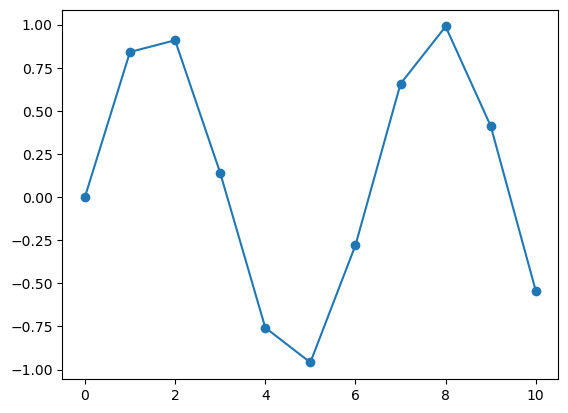

---Time for Spline in CPU  with np.interp 0.0006093978881835938 seconds


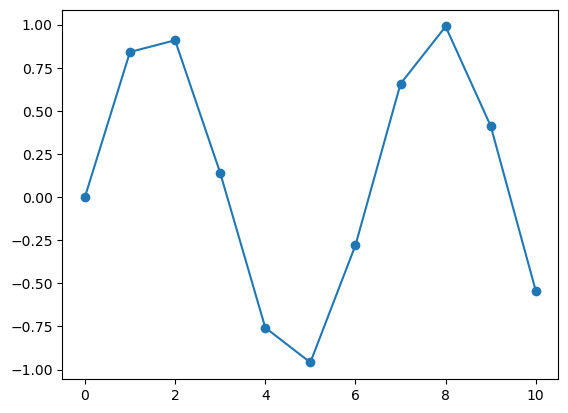

In [21]:
'Comparison and Execution Time'
import cupy as cp

x1 = cp.linspace(0, 10, 11)
y1= cp.sin(x1)
x_new1 = cp.linspace(0, 10, 201)

start_time=time.time()
z1 = cubic_interp1d_gpu(x_new1, x1, y1)
Time_GPU_spline=time.time()-start_time
print("---Time for Spline in GPU %s seconds" %(Time_GPU_spline))
x_new1 = cp.asnumpy(x_new1)
z1 = cp.asnumpy(z1)
x1 = cp.asnumpy(x1)
y1 = cp.asnumpy(y1)
plt.scatter(x1, y1)
plt.plot(x_new1, z1)

plt.show()

x = np.linspace(0, 10, 11)
y = np.sin(x)
plt.scatter(x, y)

x_new = np.linspace(0, 10, 201)
start_time=time.time()
z = cubic_interp1d(x_new, x, y)
Time_CPU_spline=time.time()-start_time
print("---Time for Spline in CPU %s seconds" %(Time_CPU_spline))
plt.plot(x_new, z)
plt.show()



x2 = cp.linspace(0, 10, 11)
y2 = cp.sin(x2)

x_new2 = cp.linspace(0, 10, 201)
start_time=time.time()
z2 = cp.interp(x_new2, x2, y2)
Time_GPU2_spline=time.time()-start_time
print("---Time for Spline in GPU with cp.interp 1D %s seconds" %(Time_CPU_spline))
x_new2 = cp.asnumpy(x_new2)
z2 = cp.asnumpy(z2)
x2 = cp.asnumpy(x2)
y2 = cp.asnumpy(y2)
plt.scatter(x2, y2)
plt.plot(x_new2, z2)

plt.show()

x = np.linspace(0, 10, 11)
y = np.sin(x)
plt.scatter(x, y)

x_new = np.linspace(0, 10, 201)
start_time=time.time()
z = np.interp(x_new, x, y)
Time_CPU2_spline=time.time()-start_time
print("---Time for Spline in CPU  with np.interp %s seconds" %(Time_CPU_spline))
plt.plot(x_new, z)
plt.show()





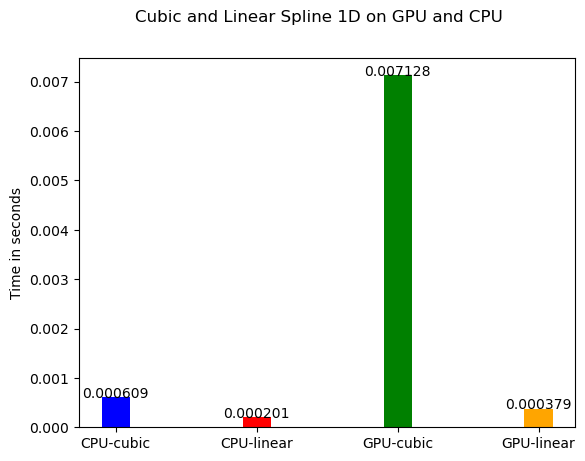

In [23]:
colors=['blue', 'red','green', 'orange']
names = ['CPU-cubic', 'CPU-linear', 'GPU-cubic', 'GPU-linear']
x_hist=[Time_CPU_spline, Time_CPU2_spline, Time_GPU_spline,Time_GPU2_spline ]
x= [0,1,2,3]

plt.bar(x, x_hist, width=0.2, align='center', color=colors)
plt.xticks(x,names)
plt.ylabel('Time in seconds')
plt.suptitle('Cubic and Linear Spline 1D on GPU and CPU')
for i in range(len(x_hist)):
        plt.text(i,x_hist[i],str("%.6f" %x_hist[i]), ha='center')
plt.show()